In [7]:
import numpy as np
import pandas as pd
import requests 
import xlsxwriter
import math
import pandas_datareader.data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates


In [8]:
data = (
            pd.read_csv(
filepath_or_buffer='small_portfolio.csv', header=[0],
index_col=0,
parse_dates=True
)
            .rename_axis(columns=['Variable'])
        )
data.head()

Variable,GE,JPM,MSFT,PG
date,,,,
2015-01-02,25.06,62.49,46.760,90.44
2015-01-05,24.60,60.55,46.325,90.01
2015-01-06,24.07,58.98,45.650,89.60
2015-01-07,24.08,59.07,46.230,90.07
2015-01-08,24.37,60.39,47.590,91.10


In [9]:
returns = data.pct_change()
returns

Variable,GE,JPM,MSFT,PG
date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.018356,-0.031045,-0.009303,-0.004755
2015-01-06,-0.021545,-0.025929,-0.014571,-0.004555
2015-01-07,0.000415,0.001526,0.012705,0.005246
2015-01-08,0.012043,0.022346,0.029418,0.011436
...,...,...,...,...
2018-03-21,0.017595,0.000872,-0.006979,-0.016218
2018-03-22,-0.038184,-0.041747,-0.029087,-0.008178
2018-03-23,-0.020974,-0.026739,-0.029068,-0.006544


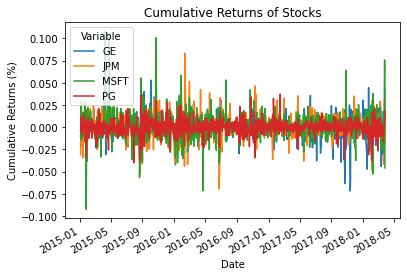

In [10]:
returns.plot()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.title('Cumulative Returns of Stocks')
plt.show()

In [11]:
meanDailyReturns = returns.mean()  # Exclude the 'portfolio' column
weights = np.array([0.5, 0.2, 0.2, 0.1])
portReturn = np.sum(meanDailyReturns * weights)

print(portReturn)

-1.6782226618545438e-05


AttributeError: module 'matplotlib.pyplot' has no attribute 'dates'

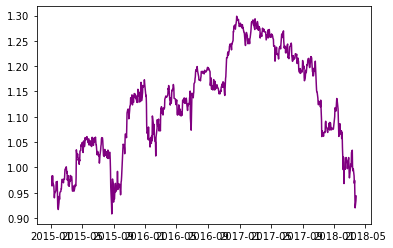

In [12]:
# Create portfolio returns column
returns['Portfolio']= returns.dot(weights)
returns.head()
# Calculate cumulative returns
daily_cum_ret=(1+returns).cumprod()


# Plot the portfolio cumulative returns only
fig, ax = plt.subplots()
ax.plot(daily_cum_ret.index, daily_cum_ret.Portfolio, color='purple', label="portfolio")
ax.xaxis.set_major_locator(plt.dates.YearLocator())
plt.legend()
plt.show()

In [13]:
daily_returns = data.pct_change()
weights = np.array([0.05, 0.4, 0.3, 0.25])

# Calculate the covariance matrix 
cov_matrix = (daily_returns.cov())*250

# Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

# Print the result
print(str(np.round(port_variance, 4) * 100) + '%')

2.55%


In [14]:
# Calculate the standard deviation by taking the square root
port_standard_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Print the results 
print(str(np.round(port_standard_dev, 4) * 100) + '%')

15.959999999999999%


In [15]:
# Calculate total rate of return from portfolio AUM
total_return = (daily_returns.iloc[-1] - daily_returns.iloc[0]) / daily_returns.iloc[0]
print(total_return)

months = 38

annualized_return = ((1 + total_return)**(12/months))-1 
print(annualized_return)

Variable
GE     NaN
JPM    NaN
MSFT   NaN
PG     NaN
dtype: float64
Variable
GE     NaN
JPM    NaN
MSFT   NaN
PG     NaN
dtype: float64


In [16]:
sp500_value = (
            pd.read_csv(
filepath_or_buffer='sp500.csv', header=[0],
index_col=0,
parse_dates=True
)
            .rename_axis(columns=['Variable'])
        )
sp500_value

Variable,S&P500
date,
2015-02-01,2058.199951
2015-05-01,2020.579956
2015-06-01,2002.609985
2015-07-01,2025.900024
2015-08-01,2062.139893
...,...
2019-03-13,2810.919922
2019-03-14,2808.479980
2019-03-15,2822.479980


In [17]:
total_return = (sp500_value.iloc[-1] - sp500_value.iloc[0]) / sp500_value.iloc[0]
print(total_return)

# Annualize the total return spanning 4 years
annualized_return = ((1 + total_return)**(12/48))-1
print (annualized_return)

Variable
S&P500    0.376237
dtype: float64
Variable
S&P500    0.083112
dtype: float64


In [18]:
ff = (
            pd.read_csv(
filepath_or_buffer='factors_pf_returns.csv', header=[0],
index_col=0,
parse_dates=True
)
            .rename_axis(columns=['Variable'])
        )
ff

Variable,Mkt-RF,SMB,HML,RF,pf_returns
date,,,,,
2016-04-01,-1.59,-0.83,0.53,0.000,-1.651745
2016-05-01,0.12,-0.22,0.01,0.000,0.408161
2016-06-01,-1.35,-0.12,0.00,0.000,0.325555
2016-07-01,-2.44,-0.29,0.08,0.000,-0.698259
2016-08-01,-1.11,-0.47,-0.03,0.000,-0.959352
...,...,...,...,...,...
2016-12-23,0.19,0.56,-0.52,0.001,0.438153
2016-12-27,0.27,0.21,0.13,0.001,0.430411
2016-12-28,-0.87,-0.27,0.08,0.001,-0.903525


In [19]:
rfr = ff['RF'].mean()
rfr

0.0008412698412698419

In [20]:
returns_sp500 = sp500_value.pct_change()
print(returns_sp500)

Variable      S&P500
date                
2015-02-01       NaN
2015-05-01 -0.018278
2015-06-01 -0.008893
2015-07-01  0.011630
2015-08-01  0.017888
...              ...
2019-03-13  0.006950
2019-03-14 -0.000868
2019-03-15  0.004985
2019-03-18  0.003706
2019-03-19 -0.000131

[1059 rows x 1 columns]


In [21]:
# Calculate annualized volatility from the standard deviation
vol_sp500 = returns_sp500.std() * np.sqrt(250)
print(vol_sp500)

Variable
S&P500    0.136136
dtype: float64


In [22]:
print(annualized_return)

Variable
S&P500    0.083112
dtype: float64


In [23]:
# Calculate the Sharpe ratio 
sharpe_ratio = ((annualized_return - rfr) / vol_sp500)
print (sharpe_ratio)

Variable
S&P500    0.604324
dtype: float64


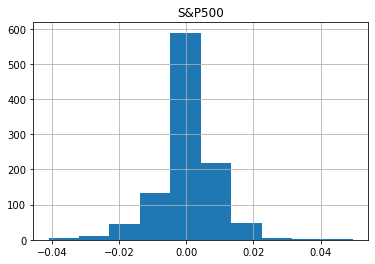

In [24]:
returns_sp500.hist()
plt.show()

In [25]:
# Print the mean
print("mean : ", returns_sp500.mean()*100)

# Print the standard deviation
print("Std.dev  : ", returns_sp500.std()*100)

# Print the skewness
print("skew : ", returns_sp500.skew())

# Print the kurtosis
print("kurt : ", returns_sp500.kurtosis())

mean :  Variable
S&P500    0.0339
dtype: float64
Std.dev  :  Variable
S&P500    0.861002
dtype: float64
skew :  Variable
S&P500   -0.383199
dtype: float64
kurt :  Variable
S&P500    3.922391
dtype: float64


skew :  Variable
GE           0.177313
JPM          0.018815
MSFT         0.515431
PG          -0.259934
Portfolio   -0.159476
dtype: float64
kurt :  Variable
GE           7.766370
JPM          3.831448
MSFT         9.882177
PG           2.848092
Portfolio    3.547200
dtype: float64


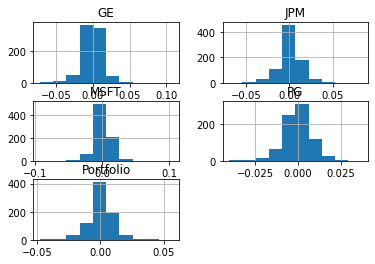

In [26]:
# Print the histograms of the stocks in the portfolio
returns.hist()

# Print skewness and kurtosis of the stocks
print ("skew : ", returns.skew())
print ("kurt : ", returns.kurtosis())

In [27]:
pf_returns = sp500_value.pct_change()
pf_returns

Variable,S&P500
date,
2015-02-01,NaN
2015-05-01,-0.018278
2015-06-01,-0.008893
2015-07-01,0.011630
2015-08-01,0.017888
...,...
2019-03-13,0.006950
2019-03-14,-0.000868
2019-03-15,0.004985


In [28]:
target = 0.8
downside_returns = pf_returns.loc[pf_returns['S&P500'] < target]

# Calculate expected return and std dev of downside
expected_return = pf_returns['S&P500'].mean()
down_stdev = downside_returns.std()

# Calculate the sortino ratio
sortino_ratio = (expected_return - rfr) / down_stdev

# Print the results
print("Expected return: ", expected_return * 100)
print("Downside risk: ", down_stdev * 100)
print("Sortino ratio: ", sortino_ratio)


Expected return:  0.03389998442910263
Downside risk:  Variable
S&P500    0.861002
dtype: float64
Sortino ratio:  Variable
S&P500   -0.058336
dtype: float64


In [33]:
# Calculate the max value 
roll_max = returns.rolling(center=False,min_periods=1,window=252).max()

# Calculate the daily draw-down relative to the max
daily_draw_down = returns/roll_max - 1

max_daily_draw_down = daily_draw_down.rolling(center=False,min_periods=1,window=252).min()

date = returns['date']

# Plot the results
plt.figure(figsize=(15, 15))
plt.plot(date, daily_draw_down, label='Daily drawdown')
plt.plot(date, max_daily_draw_down, label='Maximum daily drawdown in time-window')
plt.legend()
plt.show()

KeyError: 'date'